# Plots of the results

This notebook contains the plots of the results of the assignment 2 of the Foundations of HPC course.

All results are compared to the theoretical peak performance of the orfeo nodes.

The theoretical peak performance can be computed as:
$$Flops_{peak} = n_{cores} \times frequency \times (\frac{FLOP}{cycle})$$

### AMD EPYC™ 7H12

- $n_{cores} = 64$
- $frequency = 2.6$ GHz
- AMD Epyc 7H12 can reach at most $\frac{FLOP}{cycle} = 32$ operations per second regarding the floating point (single precision) operations and $\frac{FLOP}{cycle} = 16$ operations per second for the double precision operations.
- The theoretical peak performance is then $64 \times 2.6 \times 32 =  5324.8$ GFlops for single precision and $64 \times 2.6 \times 16 = 2662.4$ GFlops for double precision.

### Intel® Xeon® Gold 6126

- $n_{cores} = 12$
- $frequency = 2.6$ GHz
- The theoretical peak performance for an entire node is $1997$ GFlops (data found in the course material), half of the available cores are used (12 out of 24).
- For this experiment, the theoretical peak performance is then $\frac{1997}{2} = 998.5$ GFlops for double precision and $998.5 \cdot 2 = 1997$ Gflops for single precision.

In [2]:
# Load libraries

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

For each test, the mean gflops are computed, grouping the observations by size and by the number of threads. The results are then plotted in a line plot, with the mean gflops on the y-axis, and either the matrix size or the number of used cores on the x axis.

In [19]:
# This function summarizes the results of the experiments

def get_summary(test = 'size_scaling', lib = 'mkl', node = "EPYC", precision = "float", policy = "spread"):

    match test:

        case 'size_scaling':

            ## Load data
            data_path = f"results/size_scaling/size_scaling_{node}_{lib}_{precision}_{policy}.csv"
            data = pd.read_csv(data_path)
            
            ## Compute mean gflops grouped by matrix size
            summary = data.groupby(['size']).mean('gflops').reset_index()
            return summary
        
        case 'core_scaling':

            ## Load data
            data_path = f"results/core_scaling/core_scaling_{node}_{lib}_{precision}_{policy}.csv"
            data = pd.read_csv(data_path)

            ## Compute mean time grouped by matrix size
            summary = data.groupby(['n_cores']).mean('time').reset_index()
            return summary
            

# Size scaling

## EPYC nodes - single precision

In [4]:
# Gather data for the plot

node = 'EPYC'
precision = 'float'

policy = 'spread'
ss_mkl_float_spread = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_float_spread = get_summary(
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
ss_mkl_float_close = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_float_close = get_summary(
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
ss_mkl_float_spread['test'] = 'MKL - spread'
ss_oblas_float_spread['test'] = 'OBLAS - spread'
ss_mkl_float_close['test'] = 'MKL - close'
ss_oblas_float_close['test'] = 'OBLAS - close'

## Concatenate dataframes
ss_epyc_float = pd.concat([
    ss_mkl_float_spread, 
    ss_oblas_float_spread, 
    ss_mkl_float_close, 
    ss_oblas_float_close
    ])

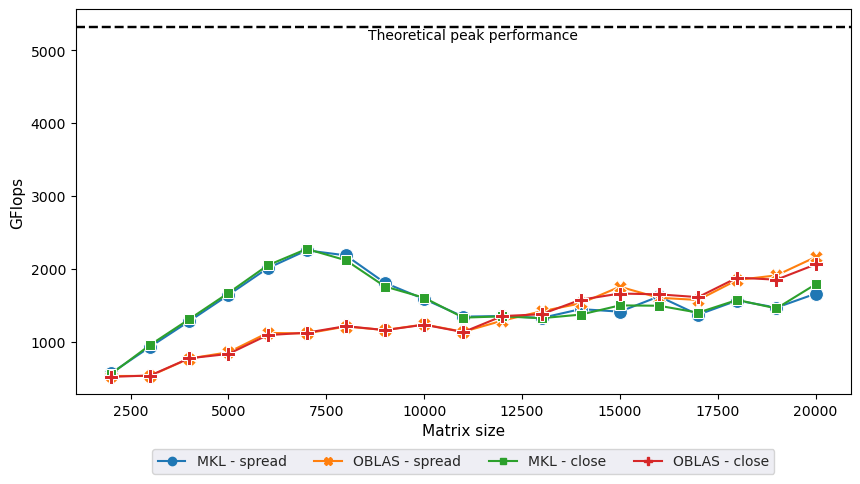

In [5]:
# Plot the results

plt.figure(figsize=(10, 5))
## Result lines
sns.lineplot(x='size',
             y='gflops', 
             hue='test', 
             data=ss_epyc_float, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             ).axhline(y=5324.8,        ## Theoretical peak performance line
                       color='black', 
                       linestyle='--', 
                       linewidth=1.75)
plt.text(x=11250, y=5210, s='Theoretical peak performance', va='center', ha='center')
## Styling
sns.set_style('darkgrid')
plt.ylabel('GFlops', fontsize=11)
plt.xlabel('Matrix size', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/size_scaling_epyc_float.png', dpi=1200, bbox_inches='tight')
plt.show()

None of the libraries reaches the theoretical peak performance.

OBLAS shows better results with bigger matrices, while MKL seem better with small matrices.

Changing binding policy doesn't seem to do much.

## EPYC nodes - double precision

In [7]:
# Gather data for the plot

node = 'EPYC'
precision = 'double'

policy = 'spread'
ss_mkl_double_spread = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_double_spread = get_summary(
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
ss_mkl_double_close = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_double_close = get_summary(
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
ss_mkl_double_spread['test'] = 'MKL - spread'
ss_oblas_double_spread['test'] = 'OBLAS - spread'
ss_mkl_double_close['test'] = 'MKL - close'
ss_oblas_double_close['test'] = 'OBLAS - close'

## Concatenate dataframes
ss_epyc_double = pd.concat([
    ss_mkl_double_spread, 
    ss_oblas_double_spread, 
    ss_mkl_double_close, 
    ss_oblas_double_close
    ])


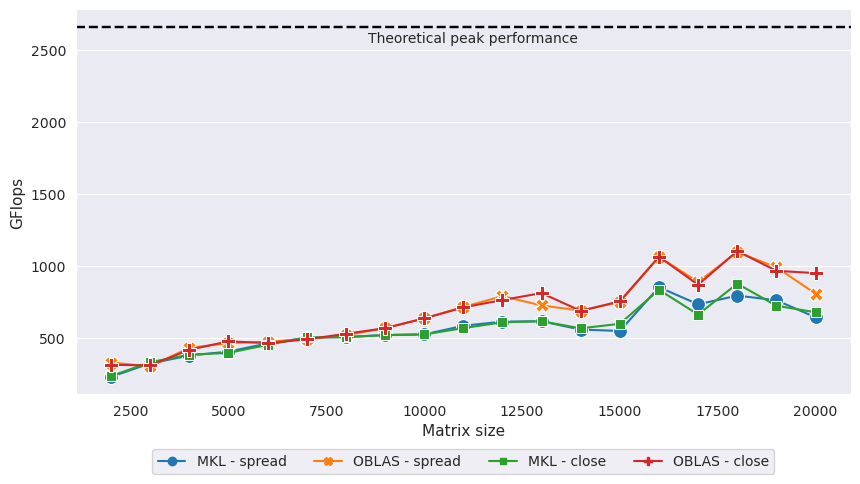

In [ ]:
# Plot the results

plt.figure(figsize=(10, 5))
## Result lines
sns.lineplot(x='size',
             y='gflops', 
             hue='test', 
             data=ss_epyc_double, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             ).axhline(y=2662.4,        ## Theoretical peak performance line
                       color='black', 
                       linestyle='--', 
                       linewidth=1.75)
plt.text(x=11250, y=2585, s='Theoretical peak performance', va='center', ha='center')
## Styling
sns.set_style('darkgrid')
plt.ylabel('GFlops', fontsize=11)
plt.xlabel('Matrix size', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/size_scaling_epyc_double.png', dpi=1200, bbox_inches='tight')
plt.show()

Same considerations as before, but here MKL doesn't peak in performance with small matrices.

## THIN nodes - single precision

In [8]:
# Gather data for the plot

node = 'THIN'
precision = 'float'

policy = 'spread'
ss_mkl_float_spread = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_float_spread = get_summary(
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
ss_mkl_float_close = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_float_close = get_summary(
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
ss_mkl_float_spread['test'] = 'MKL - spread'
ss_oblas_float_spread['test'] = 'OBLAS - spread'
ss_mkl_float_close['test'] = 'MKL - close'
ss_oblas_float_close['test'] = 'OBLAS - close'

## Concatenate dataframes
ss_thin_float = pd.concat([
    ss_mkl_float_spread, 
    ss_oblas_float_spread, 
    ss_mkl_float_close, 
    ss_oblas_float_close
    ])

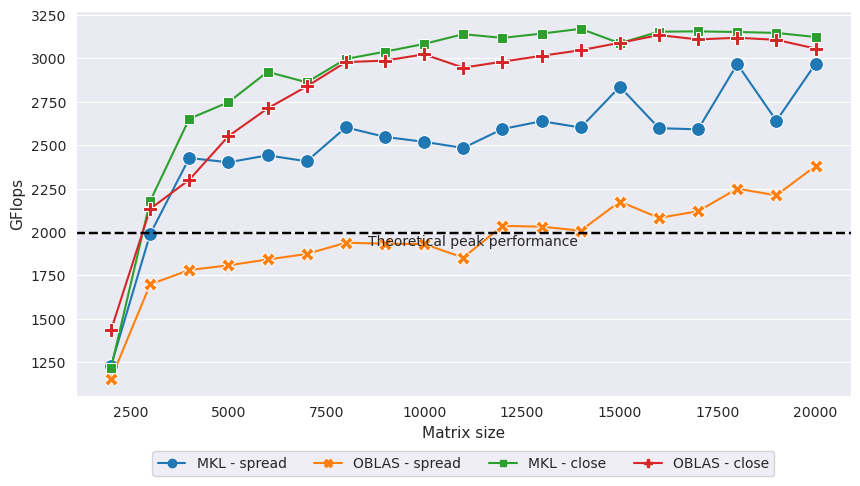

In [ ]:
# Plot the results

plt.figure(figsize=(10, 5))
## Result lines
sns.lineplot(x='size',
             y='gflops', 
             hue='test', 
             data=ss_thin_float, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             ).axhline(y=1997,        ## Theoretical peak performance line
                       color='black', 
                       linestyle='--', 
                       linewidth=1.75)
plt.text(x=11250, y=1945, s='Theoretical peak performance', va='center', ha='center')
## Styling
sns.set_style('darkgrid')
plt.ylabel('GFlops', fontsize=11)
plt.xlabel('Matrix size', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/size_scaling_thin_float.png', dpi=1200, bbox_inches='tight')
plt.show()

## THIN nodes - double precision

In [11]:
# Gather data for the plot

node = 'THIN'
precision = 'double'

policy = 'spread'
ss_mkl_double_spread = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_double_spread = get_summary(
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
ss_mkl_double_close = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_double_close = get_summary(
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
ss_mkl_double_spread['test'] = 'MKL - spread'
ss_oblas_double_spread['test'] = 'OBLAS - spread'
ss_mkl_double_close['test'] = 'MKL - close'
ss_oblas_double_close['test'] = 'OBLAS - close'

## Concatenate dataframes
ss_thin_double = pd.concat([
    ss_mkl_double_spread, 
    ss_oblas_double_spread, 
    ss_mkl_double_close, 
    ss_oblas_double_close
    ])

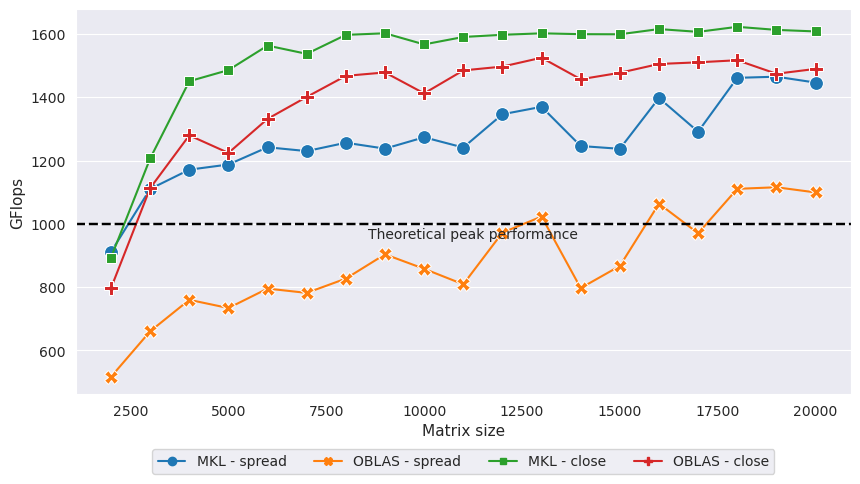

In [ ]:
# Plot the results

plt.figure(figsize=(10, 5))
## Result lines
sns.lineplot(x='size',
             y='gflops', 
             hue='test', 
             data=ss_thin_double, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             ).axhline(y=998.5,        ## Theoretical peak performance line
                       color='black', 
                       linestyle='--', 
                       linewidth=1.75)
plt.text(x=11250, y=967, s='Theoretical peak performance', va='center', ha='center')
## Styling
sns.set_style('darkgrid')
plt.ylabel('GFlops', fontsize=11)
plt.xlabel('Matrix size', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/size_scaling_thin_double.png', dpi=1200, bbox_inches='tight')
plt.show()

# Core scaling

## EPYC nodes - single precision

## EPYC nodes - double precision

## THIN nodes - single precision

## THIN nodes - double precision